In [16]:
from sklearn.model_selection import train_test_split
#utils data visualization
from utils.visualization import *
from utils.constants import *
from utils.plot_themes import *
from utils.model_utils import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.compose import ColumnTransformer

import shap



In [23]:
df = load_and_info('data/df_investig_INR.csv')

,Column,Dtype,Missing,Unique,Sample values
0,Unnamed: 0,int64,0,133,"[0, 1, 2, 3, 4]"
1,CODI_PACIENT,object,0,133,"[ID0009, ID0044, ID0046, ID0073, ID0079, ID009..."
2,INR,float64,0,75,"[4.3, 2.8, 2.12, 2.77, 2.36]"
3,ALANINA AMINOTRANSFERASA (ALT) (GPT),float64,0,32,"[33.4, 40.29, 204.0, 11.0, 42.33]"
4,"ALANINA AMINOTRANSFERASA (GPT/ALT), SUERO",float64,0,57,"[9.6, 23.02, 19.2, 16.2, 16.5]"
...,...,...,...,...,...
75,RDW,float64,0,55,"[14.9, 14.4, 20.5, 13.3, 15.75]"
76,VCM,float64,0,62,"[90.5, 103.26, 86.4, 95.5, 81.9]"
77,Volumen corpuscular medio,float64,0,87,"[95.7, 92.63, 91.5, 80.6, 94.5]"
78,DIAGNÒSTIC ASSOCIAT,object,0,20,"[FIBRIL·LACIÓ AURICULAR NO ESPECIFICADA, ALETE..."



El juego de datos contiene 80 variables y 133 observaciones, de las cuales 0 son duplicadas.


In [24]:
target_column = 'INR' 
X = df.drop(columns=[target_column, 'CODI_PACIENT'])
y = df[target_column]

# X_train_full: 70% para Entrenamiento y Validación.
# X_test_full: 30% que contiene el Calibración y Prueba (el nuevo set completo de "test").
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.30, random_state=23)

# Paso 2: Dividir el 70% de entrenamiento (X_train_full) -> Entrenamiento (55%) y Validación (15%).
# El set de validación es 15% / 70% ≈ 0.21428 del conjunto X_train_full.
TEST_SIZE_VAL = 0.15 / 0.70

X_train, X_validate, y_train, y_validate = train_test_split(X_train_full, y_train_full, test_size=TEST_SIZE_VAL, random_state=23)

# Dividir el 30% restante de test (X_test_full) -> Calibración (15%) y Prueba (15%).
# Mismo tamaño, por lo que el test_size es 0.5 (la mitad).

# Nota: La convención original era test=20% y cal=80% del 25%, ahora son ambos 50% del 30%.
X_test, X_calibration, y_test, y_calibration = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=23)

In [25]:
# Listas con los nombres de las columnas categóricas
categorical = df.select_dtypes(exclude ='number').columns.tolist()
print(categorical)

if 'CODI_PACIENT' in categorical:
    categorical.remove('CODI_PACIENT')

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Usar handle_unknown
ohe = ColumnTransformer(
    transformers=[('ohe', encoder, categorical)],
    remainder='passthrough',
    verbose_feature_names_out=False
)
ohe.set_output(transform="pandas")
ohe.fit(X_train) # Ajustamos solo en Entrenamiento

X_train_processed = ohe.transform(X_train)
X_val_processed = ohe.transform(X_validate)
X_test_processed = ohe.transform(X_test)
X_cal_processed = ohe.transform(X_calibration)

['CODI_PACIENT', 'DIAGNÒSTIC ASSOCIAT', 'INR_Group']


In [26]:
# Filtramos las columnas que han sido codificadas, esto es, contienen _ en el nombre
encoded_cols = [col for col in X_train_processed.columns if "_" in col]

display(X_train_processed[encoded_cols])

,DIAGNÒSTIC ASSOCIAT_ALETEIG [FLUTTER] AURICULAR NO ESPECIFICAT,DIAGNÒSTIC ASSOCIAT_ALTRES TIPUS D'EMBÒLIA PULMONAR SENSE COR PULMONAR AGUT,DIAGNÒSTIC ASSOCIAT_ALTRES TIPUS DE DESPOLARITZACIÓ PREMATURA,DIAGNÒSTIC ASSOCIAT_ARRÍTMIA CARDÍACA NO ESPECIFICADA,DIAGNÒSTIC ASSOCIAT_FIBRIL·LACIÓ AURICULAR CRÒNICA,DIAGNÒSTIC ASSOCIAT_FIBRIL·LACIÓ AURICULAR NO ESPECIFICADA,DIAGNÒSTIC ASSOCIAT_FIBRIL·LACIÓ AURICULAR PAROXISMAL,DIAGNÒSTIC ASSOCIAT_FIBRIL·LACIÓ AURICULAR PERMANENT,DIAGNÒSTIC ASSOCIAT_FLEBITIS I TROMBOFLEBITIS VASOS PROFUNDS NE EXTREM. INF. NE,DIAGNÒSTIC ASSOCIAT_HEMORRÀGIA SUBDURAL NO TRAUMÀTICA NO ESPECIFICADA,DIAGNÒSTIC ASSOCIAT_INFART CEREBRAL NO ESPECIFICAT,DIAGNÒSTIC ASSOCIAT_MIOCARDIOPATIA DILATADA,DIAGNÒSTIC ASSOCIAT_SÍNCOPE I COL·LAPSE,"DIAGNÒSTIC ASSOCIAT_SÍNDROME POSTTROMBÒTICA SENSE COMPLICACIONS, EXTREMITAT NE",DIAGNÒSTIC ASSOCIAT_TAQUICÀRDIA PAROXISMAL NO ESPECIFICADA,DIAGNÒSTIC ASSOCIAT_TRASTORN NO REUMÀTIC DE LA VÀLVULA AÒRTICA NO ESPECIFICAT,DIAGNÒSTIC ASSOCIAT_ÚS D'ANTICOAGULANTS A LLARG TERMINI (ACTUAL),INR_Group_Alto (>3.0),INR_Group_Bajo (<2.0),INR_Group_Normal (2.0-3.0)
62,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
80,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
103,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [27]:
# Lista con los nombres de las columnas numéricas 
numerical = df.select_dtypes(include = 'number').columns.drop('INR').tolist()

In [28]:
for df in [X_train_processed, X_val_processed, X_test_processed, X_cal_processed]:
    df.columns = df.columns.str.replace('[', '_', regex=False)\
                           .str.replace(']', '_', regex=False)\
                           .str.replace('<', '_', regex=False)\
                           .str.replace('>', '_', regex=False)

In [29]:

# Estandarizamos el conjunto de entrenamiento
scaler = StandardScaler()

# Configuramos ahora ColumnTransformer para evitar las ya codificadas
norm = ColumnTransformer(
    transformers=[('norm', scaler, numerical)],
    remainder='passthrough', # keep any other columns unchanged
    verbose_feature_names_out=False
)
# La salida como dataframe
norm.set_output(transform="pandas")
norm.fit(X_train_processed) # Ajustamos solo en Entrenamiento procesado

X_train_scaled = norm.transform(X_train_processed)
X_val_scaled = norm.transform(X_val_processed) # Transformamos Validación

X_test_scaled = norm.transform(X_test_processed)
X_cal_scaled = norm.transform(X_cal_processed)

In [30]:
import re
def clean_feature_names(df):
    """Remove special JSON characters from column names"""
    df = df.copy()
    df.columns = [re.sub(r'[^A-Za-z0-9_]', '_', str(col)) for col in df.columns]
    return df

# Clean your training data columns
X_train_scaled = clean_feature_names(X_train_scaled)
X_test_scaled = clean_feature_names(X_test_scaled)

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Inicializar y ajustar el modelo (limitamos la profundidad para mantener la interpretabilidad)
dt_model = DecisionTreeRegressor(max_depth=4, random_state=23)

#evaluate_model(y_test, dt_pred,'Arboles de decisión')


# 4. Aplicación de métodos de explicabilidad

--- Gráfico Global de Importancia de Características SHAP (DT) ---


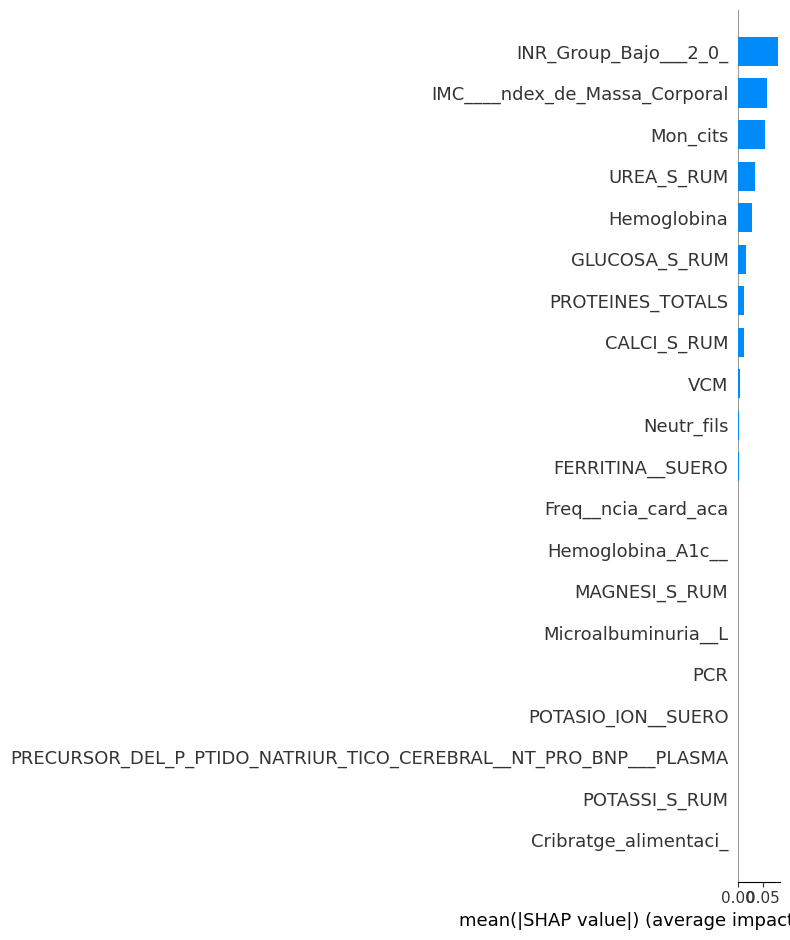


--- Gráfico de Resumen de Impacto de Características SHAP (DT) ---


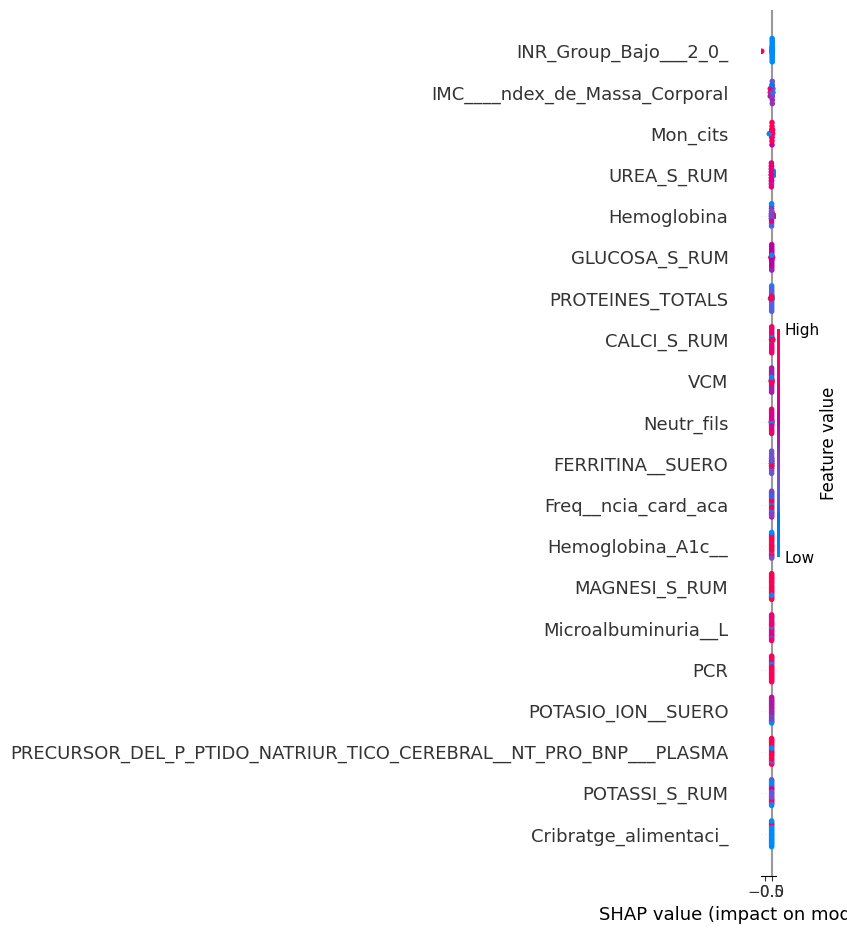

In [33]:
# Asumimos que el Árbol de Decisión ajustado (dt_model) está listo
dt_model.fit(X_train_scaled, y_train)

# Inicializa el Explainer SHAP
explainer = shap.Explainer(dt_model) 

# Calcula los valores de Shapley para el set de Prueba (X_test_scaled)
shap_values = explainer(X_test_scaled) 

# 1. Gráfico de Importancia de Características (Global)
print("--- Gráfico Global de Importancia de Características SHAP (DT) ---")
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

# 2. Gráfico de Impacto Global (Dot Plot/Bee Swarm)
print("\n--- Gráfico de Resumen de Impacto de Características SHAP (DT) ---")
shap.summary_plot(shap_values, X_test_scaled)